https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da

https://multithreaded.stitchfix.com/blog/2020/08/05/bandits/

https://en.wikipedia.org/wiki/Multi-armed_bandit

In [1]:
from typing import List 
import random
from dataclasses import dataclass
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline

def random_mu_list(size: int):
    return np.random.normal(0, 1, size)

def sequential_mu_list(size: int):
    return np.linspace(0, size - 1, size)

def custom_mu(mu_list: List[float]):
    return np.array(mu_list)


class EpsilonGreedyBandit:
    """
    Epsilon-Greedy multi-armed bandit processor

    mu_list: list of average reward for each arm.
    """

    def __init__(self, explore_prob: float, num_steps: int, mu_list: List[float]):
        self.number_of_arms = len(mu_list)
        self.explore_prob = explore_prob
        self.num_steps = num_steps
        self.step_count = 0
        self.arm_counts = np.zeros(self.number_of_arms)
        self.arm_rewards = np.zeros(self.number_of_arms)
        self.mean_reward = 0
        self.step_rewards = np.zeros(num_steps)
        self.mu_list = mu_list.copy()
        self.num_rands = 0

    def pull(self):
        curr_val = np.random.rand()
        if self.explore_prob == 0 and self.step_count == 0:
            # Know nothing at this point, just pick an arm.
            arm = np.random.choice(self.number_of_arms)
            self.num_rands += 1
        elif curr_val < self.explore_prob:  
            # Select an arm randomly
            self.num_rands += 1
            arm = np.random.choice(self.number_of_arms)
        else:  
            # Continue to exploit the best (greedy)
            arm = np.argmax(self.arm_rewards)
        reward = np.random.normal(self.mu_list[arm], 1)
        self.step_count += 1
        self.arm_counts[arm] += 1
        # Update rewards values
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.step_count
        self.arm_rewards[arm] = self.arm_rewards[arm] + (reward - self.arm_rewards[arm]) / self.arm_counts[arm]
        
 
    def run(self):
        for step in range(self.num_steps):
            self.pull()
            self.step_rewards[step] = self.mean_reward
        if False and self.explore_prob == 0:
            print('[[')
            print(self.arm_rewards)
            print(f'Num: {self.num_rands}')
            print(']]')

                



  Last step average rewards
    Epsilon=0    -> Reward = 0.81
    Epsilon=0.01 -> Reward = 1.41
    Epsilon=0.05 -> Reward = 1.89
    Epsilon=0.1  -> Reward = 1.93
 


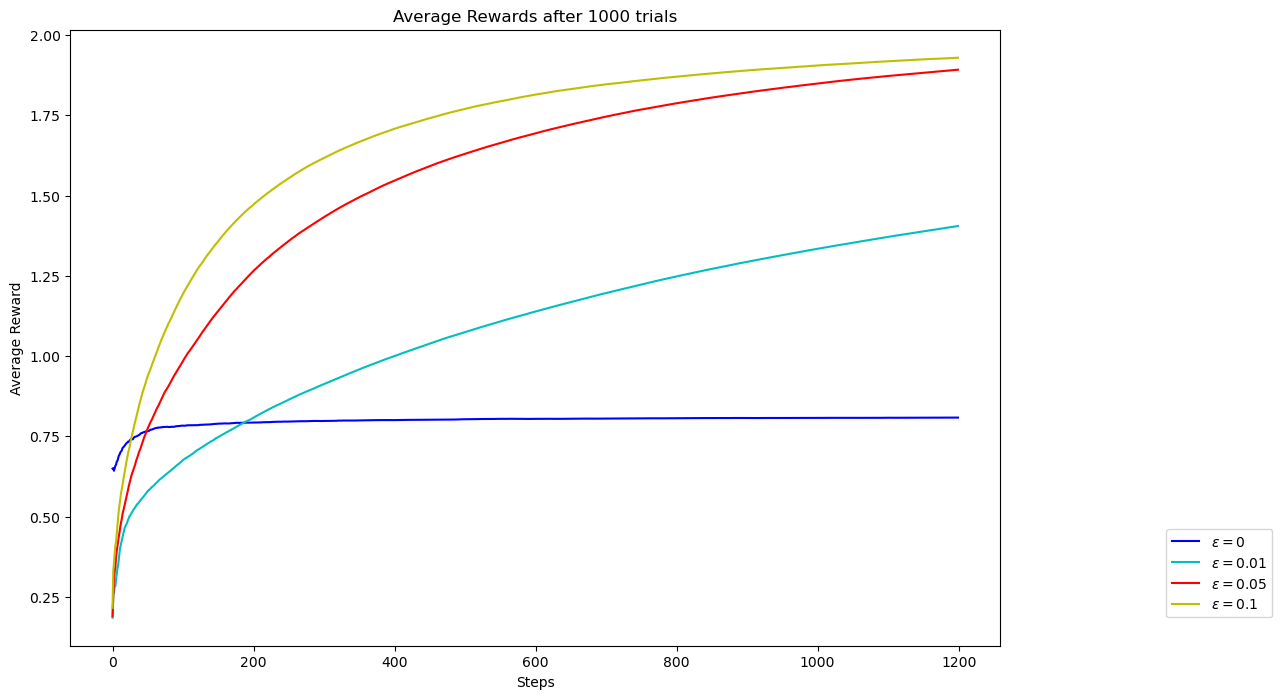

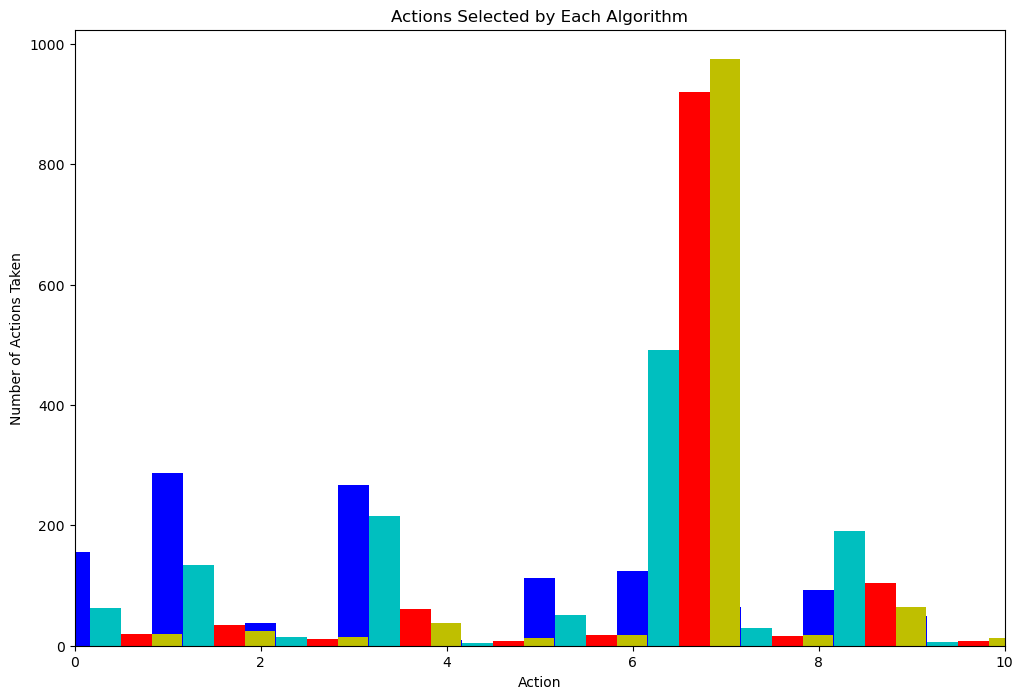

NameError: name 'k' is not defined

In [2]:
from IPython.display import display, HTML

@dataclass
class RewardRecs:
    title: str
    reward_list: List[float]
    avg_arm_counts: List[int]

class ExperimentProcessor:
    def __init__(self, bandit_mus, trials, probs_explore, num_steps):
        self.mu_list = np.array(bandit_mus)
        self.trials = trials 
        self.probs_explore = probs_explore
        self.num_steps = num_steps
        self.rewards_recs = []
        
    def capture_experiment(self, curr_prob):
        rewards = np.zeros(self.num_steps)
        arm_counts = np.zeros(len(self.mu_list))

        for trial_num in range(1, self.trials+1):
            bandit = EpsilonGreedyBandit(curr_prob, self.num_steps, self.mu_list)
            bandit.run()
            rewards = rewards + (bandit.step_rewards - rewards) / trial_num
            arm_counts = arm_counts + (bandit.arm_counts - arm_counts) / trial_num
        self.rewards_recs.append(
            RewardRecs(
                title=str(curr_prob), 
                reward_list=rewards,
                avg_arm_counts=arm_counts))

   
    def plot_experiments(self):
        color_list = ['b', 'c', 'r', 'y', 'g', 'k']
        plt.figure(figsize=(12,8))
        for idx, epx_rec in enumerate(self.rewards_recs):
            plt.plot(
                epx_rec.reward_list, color=color_list[idx],
                label="$\epsilon={0}$".format(epx_rec.title))
        plt.legend(bbox_to_anchor=(1.3, 0.2))
        plt.xlabel("Steps")
        plt.ylabel("Average Reward")
        plt.title(f"Average Rewards after {trials} trials")
        plt.show()
    
    def report_arm_frequencies(self):
        bar_width = 0.33
        number_of_arms = len(bandit_mus)
        bins = np.linspace(0, number_of_arms-1, number_of_arms)
        plt.figure(figsize=(12,8))
        color_list = ['b', 'c', 'r', 'y', 'g', 'k']
        for idx, epx_rec in enumerate(self.rewards_recs):
            plt.bar(bins+(idx*bar_width), epx_rec.avg_arm_counts, 
                width = bar_width, color=color_list[idx], 
                label="$\epsilon={0}$".format(epx_rec.title))
        plt.xlim([0,number_of_arms])
        plt.title("Actions Selected by Each Algorithm")
        plt.xlabel("Action")
        plt.ylabel("Number of Actions Taken")
        plt.show()
        
        
        arm_counts = np.array(
            [rec.avg_arm_counts for rec in self.rewards_recs])
        perc_arm_counts = [((avg_ct/np.sum(avg_ct))*100).astype(int) for avg_ct in arm_counts]
        titles = ["$\epsilon={0}$".format(rec.title) for rec in self.rewards_recs]
        df = pd.DataFrame(perc_arm_counts, index=titles,
        columns=["Arm " + str(x) for x in range(0, k)])
        print("Percentage of actions selected:")
        display(HTML(df.to_html()))
        
    def report(self):
        for curr_prob in self.probs_explore:
            self.capture_experiment(curr_prob)
        print('  Last step average rewards')
        for rec in self.rewards_recs:
            print('    Epsilon={0:<4} -> Reward = {1:.2f}'.format(
                rec.title, rec.reward_list[-1]))
        print(' ')
        self.plot_experiments()
        self.report_arm_frequencies()
        
    
trials = 1000
number_of_steps = 1200
# random.seed(10)
bandit_mus = [0.21, 0.5, 0.11, 1.00, 0.04, 0.64, 2.20, 0.65, 1.32, 0.27]
probs_to_explore = [0, 0.01, 0.05, 0.1]
exp_proc = ExperimentProcessor(bandit_mus, trials, probs_to_explore, number_of_steps)
exp_proc.report()


In [ ]:
values = [random.choice(bandit_mus) for _ in range(1000)]
sum(values)/len(values)         

In [ ]:

sum(bandit_mus)/len(bandit_mus)

In [ ]:

k = 10
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

episodes = 1000
random.seed(2000)


# Run experiments
for i in range(episodes):
    # Initialize bandits
    # random_mu = random_mu_list(k)
    eps_0 = EpsilonGreedyBandit(0, iters, random_mu)
    eps_01 = EpsilonGreedyBandit(0.01, iters, random_mu.copy())
    eps_1 = EpsilonGreedyBandit(0.1, iters, random_mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.step_rewards - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.step_rewards - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.step_rewards - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) 
    + " Episodes")
plt.show()

In [ ]:
class eps_bandit:
    """
    epsilon-greedy k-bandit problem

    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0.
        Set to "sequence" for the means to be ordered from
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    """

    def __init__(self, k, eps, iters, mu='random'):
        # Number of arms
        self.k = k
        # Search probability
        self.eps = eps
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)

        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k - 1, k)

    def pull(self):
        # Generate random number
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)

        reward = np.random.normal(self.mu[a], 1)

        # Update counts
        self.n += 1
        self.k_n[a] += 1

        # Update total
        self.mean_reward = self.mean_reward + (
                reward - self.mean_reward) / self.n

        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
                reward - self.k_reward[a]) / self.k_n[a]

    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward

    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

In [ ]:
k = 10
iters = 1200

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = eps_bandit(k, 0, iters)
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) 
    + " Episodes")
plt.show()

In [ ]:
k = 10
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_0_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = eps_bandit(k, 0, iters, mu='sequence')
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
    # Average actions per episode
    eps_0_selection = eps_0_selection + (
        eps_0.k_n - eps_0_selection) / (i + 1)
    eps_01_selection = eps_01_selection + (
        eps_01.k_n - eps_01_selection) / (i + 1)
    eps_1_selection = eps_1_selection + (
        eps_1.k_n - eps_1_selection) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
for i in range(k):
    plt.hlines(eps_0.mu[i], xmin=0,
              xmax=iters, alpha=0.5,
              linestyle="--")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + 
     str(episodes) + " Episodes")
plt.show()

In [ ]:
bins = np.linspace(0, k-1, k)

plt.figure(figsize=(12,8))
plt.bar(bins, eps_0_selection, 
        width = 0.33, color='b', 
        label="$\epsilon=0$")
plt.bar(bins+0.33, eps_01_selection,
        width=0.33, color='g', 
        label="$\epsilon=0.01$")
plt.bar(bins+0.66, eps_1_selection, 
        width=0.33, color='r',
        label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlim([0,k])
plt.title("Actions Selected by Each Algorithm")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()

opt_per = np.array([eps_0_selection, eps_01_selection,
                   eps_1_selection]) / iters * 100
df = pd.DataFrame(opt_per, index=['$\epsilon=0$', 
    '$\epsilon=0.01$', '$\epsilon=0.1$'],
                 columns=["a = " + str(x) for x in range(0, k)])
print("Percentage of actions selected:")
df

In [ ]:
class eps_decay_bandit:
    '''
    epsilon-decay k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, iters, mu='random'):
        # Number of arms
        self.k = k
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
        
    def pull(self):
        # Generate random number
        p = np.random.rand()
        if p < 1 / (1 + self.n / self.k):
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

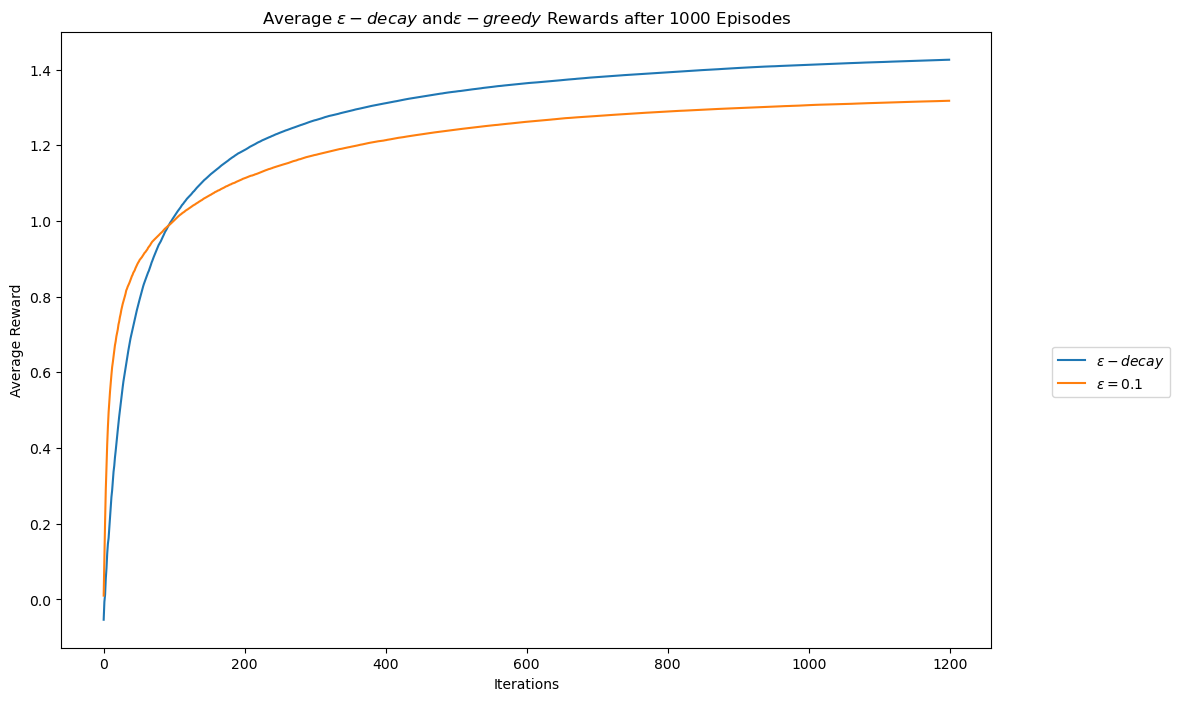

In [87]:
k = 10
iters = 1200
eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_decay = eps_decay_bandit(k, iters)
    eps_1 = eps_bandit(k, 0.1, iters, eps_decay.mu.copy())
    
    # Run experiments
    eps_decay.run()
    eps_1.run()
    
    # Update long-term averages
    eps_decay_rewards = eps_decay_rewards + (
        eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-decay$ and" + 
    "$\epsilon-greedy$ Rewards after " 
    + str(episodes) + " Episodes")
plt.show()

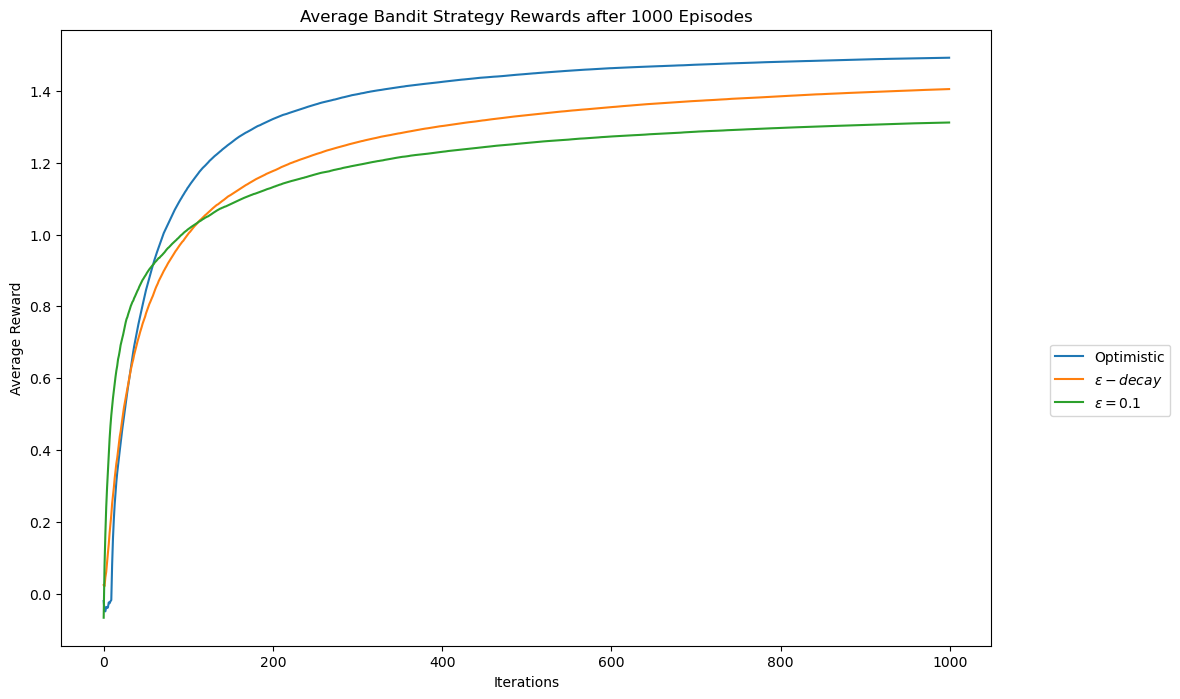

In [8]:
k = 10
iters = 1000
oiv_rewards = np.zeros(iters)
eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
# Select initial values
oiv_init = np.repeat(5., k)
episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    oiv_bandit = eps_bandit(k, 0, iters)
    oiv_bandit.k_reward = oiv_init.copy()
    oiv_bandit.k_n = np.ones(k)
    eps_decay = eps_decay_bandit(k, iters, oiv_bandit.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, oiv_bandit.mu.copy())
    
    # Run experiments
    oiv_bandit.run()
    eps_decay.run()
    eps_1.run()
    
    # Update long-term averages
    oiv_rewards = oiv_rewards + (
        oiv_bandit.reward - oiv_rewards) / (i + 1)
    eps_decay_rewards = eps_decay_rewards + (
        eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(oiv_rewards, label="Optimistic")
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Bandit Strategy Rewards after " + 
    str(episodes) + " Episodes")
plt.show()

In [9]:
df = pd.DataFrame({"number of selections": oiv_bandit.k_n - 1,
                  "actual reward": oiv_bandit.mu,
                  "estimated reward": oiv_bandit.k_reward})
df = df.applymap(lambda x: np.round(x, 2))
df['number of selections'] = df['number of selections'].astype('int')
df

,number of selections,actual reward,estimated reward
0,2,-0.80,1.65
1,3,-0.75,1.38
2,4,0.83,1.29
3,5,1.05,1.69
4,2,0.18,1.52
5,3,-0.24,1.51
6,1,-0.61,1.79
7,3,0.39,1.67
8,971,2.13,2.12
9,6,0.74,1.75
